In [1]:
from __future__ import division, print_function, absolute_import
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score
import pickle
from mltools.dataManager import DataManager
from mltools.models import baseLearner
from mltools.nnet.layers import *
from mltools.nnet.optim import sgd_momentum
from mltools.utils import one_hot

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

## Neural Net

In [3]:
class NeuralNet():
    
    def __init__(self, batch_size=32, hidden_dim=100, epochs=100, learning_rate=.001, reg=0, early_stop=10):
        self.BATCH_SIZE = batch_size
        self.HIDDEN_DIM = hidden_dim
        self.EPOCHS = epochs
        self.REG = reg
        self.LR = learning_rate
        self.NUM_CLASSES = None
        self.EARLY_STOP = early_stop
    
    
    def init_weights(self, verbose=True):
        # Initialize weights to train
        params = {}
        params['W1'] = np.random.normal(scale=.1, size=(self.INPUT_DIM, self.HIDDEN_DIM))
        params['W2'] = np.random.normal(scale=.1, size=(self.HIDDEN_DIM, self.NUM_CLASSES))
        params['b1'] = np.ones(self.HIDDEN_DIM)
        params['b2'] = np.ones(self.NUM_CLASSES)
        self.params = params
        if verbose:
            print('\nInitialized Paramaters:')
            for name, tensor in params.iteritems():
                print('%s: ' % name, tensor.shape)
                
    def train(self, x_train, y_train, x_test=None, y_test_num=None, momentum=0, num_classes=None, verbose=True):
        
        if num_classes is None:
            num_classes = int(np.max(y_train) + 1)
            self.NUM_CLASSES = num_classes
        temp = DataManager()
        temp.set_data(x_train, y_train)
        x_train, x_val, y_train_num, y_val_num = temp.test_train_split(.9)
        y_train = one_hot(y_train_num, num_class=num_classes)
        y_val = one_hot(y_val_num, num_class=num_classes)
        
        if x_test != None:
            y_test = one_hot(y_test_num, num_class=num_classes)
        
        self.INPUT_DIM = x_train.shape[1]
        self.init_weights(False)
        params = self.params
        
        # Trianing
        num_training = x_train.shape[0]
        iters_per_epoch = int(max(num_training / self.BATCH_SIZE, 1))
        num_iterations = int(self.EPOCHS * iters_per_epoch)

        # For logging results
        self.loss_hist_train = []
        self.acc_hist_train = []
        self.num_hist_train = []
        self.mse_hist_train = []

        self.num_hist_val = []
        self.mse_hist_val = []
        self.acc_hist_val = []
        self.loss_hist_val = []
        
        self.mse_hist_test = []
        self.num_hist_test = []
        self.acc_hist_test = []
        
        if verbose: print('\nStarting Training:')
        for epoch in range(self.EPOCHS):
            # Shuffle the data
            shuffle_idx = np.random.permutation(range(x_train.shape[0]))
            x_train = x_train[shuffle_idx]
            y_train = y_train[shuffle_idx]
            y_train_num = y_train_num[shuffle_idx]

            for i in range(iters_per_epoch):
                # Make minibatch
                batch_start = self.BATCH_SIZE*i
                batch_end = self.BATCH_SIZE*(i+1)
                x_batch = x_train[batch_start:batch_end]
                y_batch = y_train[batch_start:batch_end]
                y_batch_num = y_train_num[batch_start:batch_end]

                # Forward Pass
                h1, linear_cache_1 = linear_forward(x_batch, params['W1'], params['b1'])
                a1, relu_cache_1= relu_forward(h1)
                h2, linear_cache_2 = linear_forward(a1, params['W2'], params['b2'])
                a2, relu_cache_2 = relu_forward(h2)

                # Loss
                probs, loss, dx = softmax_loss(a2, y_batch_num)
                # Plus regularization
                loss += .5 * self.REG * np.sum(params['W1']**2) + .5 * self.REG * np.sum(params['W2']**2)
                self.loss_hist_train.append(loss)

                # Backwards Pass
                grads = {}
                da = relu_backward(dx, relu_cache_2)
                dx_2, grads['W2'], grads['b2'] = linear_backward(da, linear_cache_2)
                da_2 = relu_backward(dx_2, relu_cache_1)
                dx, grads['W1'], grads['b1'] = linear_backward(da_2, linear_cache_1)

                # Regularization (optional)
                grads['W2'] += self.REG * params['W2']
                grads['W1'] += self.REG * params['W1']

                # Parameter update
                for p, w in params.iteritems():
                    dw = grads[p]
                    next_w, next_config = sgd_momentum(w, dw, config={'momentum':momentum,
                                                                      'learning_rate':self.LR})
                    # Update weights
                    params[p] = next_w
    
            # Calculate the accuracy
            probs = np.exp(a2 - np.max(a2, axis=1, keepdims=True))
            probs /= np.sum(probs, axis=1, keepdims=True)
            mse = mean_squared_error(probs, y_batch)
            y_pred = np.argmax(probs, axis=1)
            train_acc = np.mean(y_pred == y_batch_num)
            num_correct = np.sum(y_pred == y_batch_num)
            self.acc_hist_train.append(train_acc)
            self.num_hist_train.append(num_correct)
            self.mse_hist_train.append(mse)

            if verbose: print("[{}] loss: {}, Acc: {}".format(epoch, loss, train_acc))
                
            # calc accuaracy on validation
            probs = self.predict(x_val, hard=False)
            mse = mean_squared_error(probs, y_val)
            y_pred = np.argmax(probs, axis=1)
            train_acc = np.mean(y_pred == y_val_num)
            num_correct = np.sum(y_pred == y_val_num)
            self.mse_hist_val.append(mse)
            self.acc_hist_val.append(train_acc)
            self.num_hist_val.append(num_correct)
            
            if x_test != None:
                # calc accuaracy on test
                probs = self.predict(x_test, hard=False)
                mse = mean_squared_error(probs, y_test)
                y_pred = np.argmax(probs, axis=1)
                train_acc = np.mean(y_pred == y_test_num)
                num_correct = np.sum(y_pred == y_test_num)
                self.mse_hist_test.append(mse)
                self.acc_hist_test.append(train_acc)
                self.num_hist_test.append(num_correct)
            
            # Early stopping
            past_acc = self.acc_hist_val[-self.EARLY_STOP:]
            if np.array_equal(past_acc[::-1], np.sort(past_acc)) and len(past_acc) == self.EARLY_STOP:
                if verbose: print("--- Early Stopping ---")
                break
            
        self.params = params  
        if verbose: print('\n---Completed Training---')
            
    def predict(self, x_test,hard=True):
        params = self.params
        h1, _ = linear_forward(x_test, params['W1'], params['b1'])
        a1, _ = relu_forward(h1)
        h2, _ = linear_forward(a1, params['W2'], params['b2'])
        a2, _ = relu_forward(h2)
        probs = np.exp(a2 - np.max(a2, axis=1, keepdims=True))
        probs /= np.sum(probs, axis=1, keepdims=True)
        if hard:
            return np.argmax(probs, axis=1)
        return probs
                  
    
    def save_model(self, output):
        pickle.dump(self.params, open(output, 'wb'))
        
    def load_model(self, in_file):
        self.params = pickle.load(open(in_file, 'rb'))
        self.HIDDEN_DIM = self.params['W1'].shape[1]

## Part 2

In [51]:
# Load data
data = DataManager('datasets/iris.arff')
data.normalize()
x_train, x_test, y_train_num, y_test_num = data.test_train_split(.75)
y_train = one_hot(y_train_num, num_class=3)
y_test = one_hot(y_test_num, num_class=3)

In [52]:
net = NeuralNet(learning_rate=.1, hidden_dim=8, batch_size=50)
net.train(x_train, y_train_num, verbose=False)
y_pred = net.predict(x_test, hard=True)
print(net.acc_hist_train[-1])

0.94


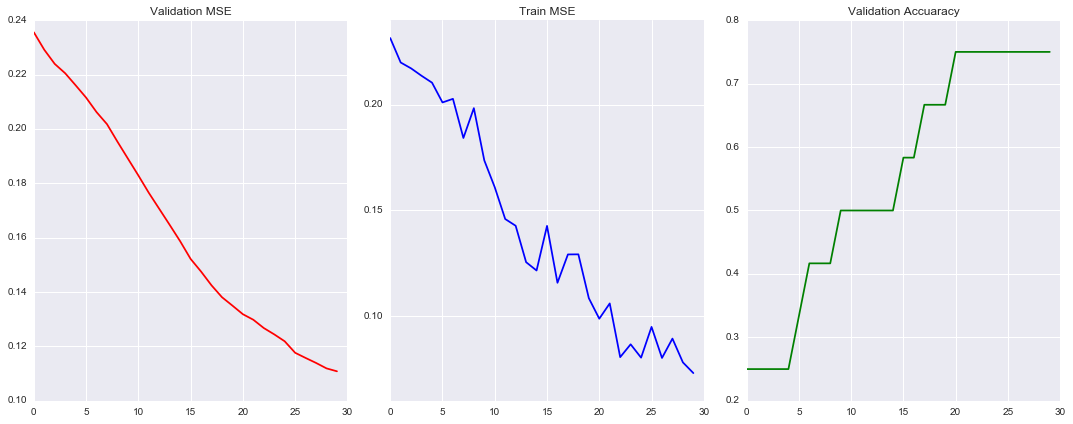

In [45]:
plt.figure(num=None, figsize=(15, 6), dpi=500, facecolor='w', edgecolor='k')

plt.subplot(131)
plt.title('Validation MSE')
plt.plot(net.mse_hist_val, c='r', label='val MSE')
plt.subplot(132)
plt.title('Train MSE')
plt.plot(net.mse_hist_train, c='b', label='train MSE')
plt.subplot(133)
plt.title('Validation Accuaracy')
plt.plot(net.acc_hist_val, c='g', label='val accuaracy')
plt.tight_layout()
plt.savefig('f.png')
plt.show()

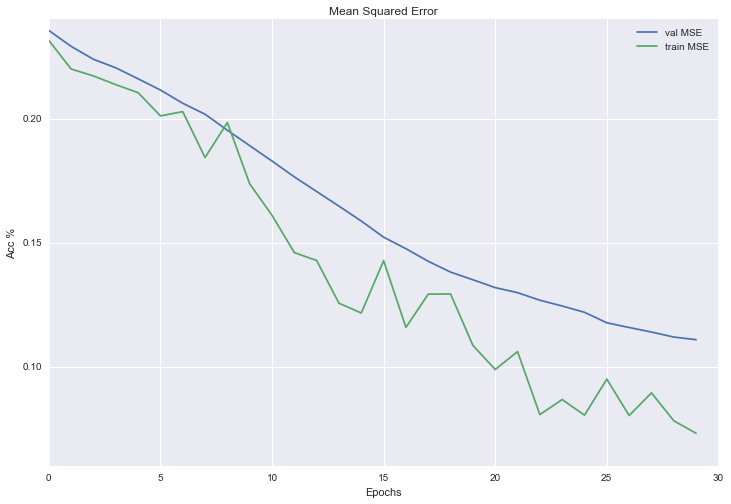

In [46]:
plt.figure(num=None, figsize=(12, 8), dpi=1000, facecolor='w', edgecolor='k')

plt.plot(net.mse_hist_val, label='val MSE')
plt.plot(net.mse_hist_train, label='train MSE')
plt.legend()
plt.title('Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('Acc %')
plt.savefig('mse.png')
plt.show()

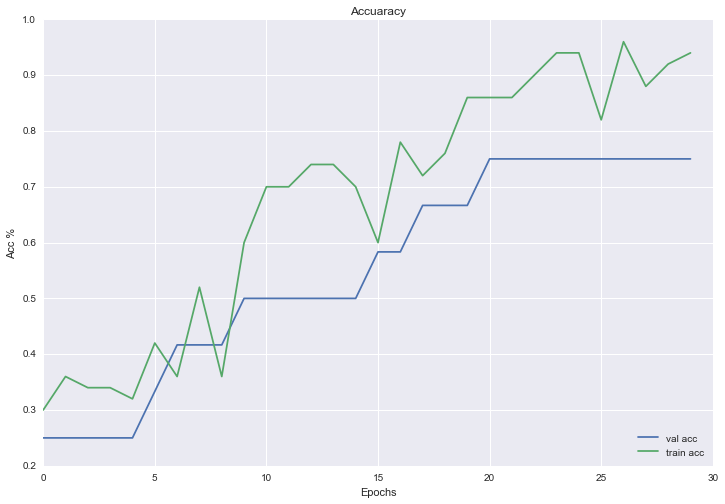

In [47]:
plt.figure(num=None, figsize=(12, 8), dpi=1000, facecolor='w', edgecolor='k')

plt.plot(net.acc_hist_val, label='val acc')
plt.plot(net.acc_hist_train, label='train acc')
plt.legend(loc='lower right')
plt.title('Accuaracy')
plt.xlabel('Epochs')
plt.ylabel('Acc %')
plt.savefig('acc.png')
plt.show()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:137: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


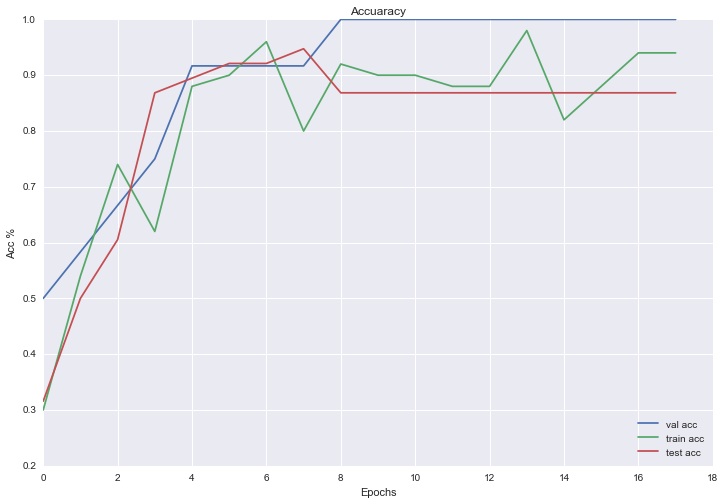

In [48]:
net = NeuralNet(learning_rate=.1, hidden_dim=8, batch_size=50, epochs=100)
net.train(x_train, y_train_num, x_test=x_test, y_test_num=y_test_num, optim='sgd', verbose=False)
y_pred = net.predict(x_test, hard=True)

plt.figure(num=None, figsize=(12, 8), dpi=1000, facecolor='w', edgecolor='k')

plt.plot(net.acc_hist_val, label='val acc')
plt.plot(net.acc_hist_train, label='train acc')
plt.plot(net.acc_hist_test, label='test acc')
plt.legend(loc='lower right')
plt.title('Accuaracy')
plt.xlabel('Epochs')
plt.ylabel('Acc %')
plt.show()

## Part 3

In [52]:
# Load data
data = DataManager('datasets/vowel.arff')
data.normalize()
x_train, x_test, y_train_num, y_test_num = data.test_train_split(.75)
y_train = one_hot(y_train_num, num_class=11)
y_test = one_hot(y_test_num, num_class=11)

In [53]:
data.attr_names

['Train or Test',
 'Speaker Number',
 'Sex',
 'Feature 0',
 'Feature 1',
 'Feature 2',
 'Feature 3',
 'Feature 4',
 'Feature 5',
 'Feature 6',
 'Feature 7',
 'Feature 8',
 'Feature 9',
 'Class']

In [54]:
net = NeuralNet(learning_rate=.01)
net.train(x_train, y_train_num, optim='sgd', verbose=False)
y_pred = net.predict(x_test)
test_acc = np.mean(y_pred == y_test_num)
print(test_acc)

0.620967741935


In [62]:
lr_results = []
for lr in [.001, .01, .1, 1, 10]:
    acc_list = []
    for i in range(5):
        data = DataManager('datasets/vowel.arff')
        data.shuffle()
        data.normalize()
        x_train, x_test, y_train_num, y_test_num = data.test_train_split(.75)
        y_train = one_hot(y_train_num, num_class=11)
        y_test = one_hot(y_test_num, num_class=11)
        
        net = NeuralNet(learning_rate=lr)
        net.train(x_train, y_train_num, optim='sgd', verbose=False)
        y_pred = net.predict(x_test)
        test_acc = np.mean(y_pred == y_test_num)
        acc_list.append(test_acc)
    avg = np.mean(acc_list)
    lr_results.append(avg)

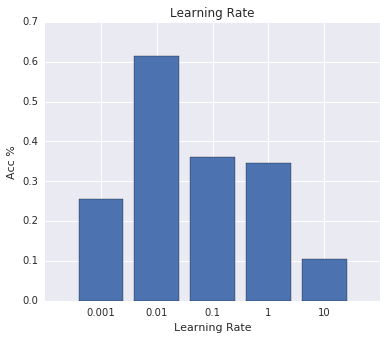

In [99]:
plt.figure(num=None, figsize=(6, 5), dpi=1000, facecolor='w', edgecolor='k')

plt.bar(range(5),lr_results,tick_label=[.001, .01, .1, 1, 10], align='center')
plt.title('Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Acc %')
plt.show()

In [151]:
net = NeuralNet(learning_rate=.01, epochs=5000,early_stop=50)
net.train(x_train, y_train_num, x_test=x_test, y_test_num=y_test_num, optim='sgd', verbose=False)
y_pred = net.predict(x_test)
test_acc = np.mean(y_pred == y_test_num)
print(test_acc)

0.721774193548


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:137: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


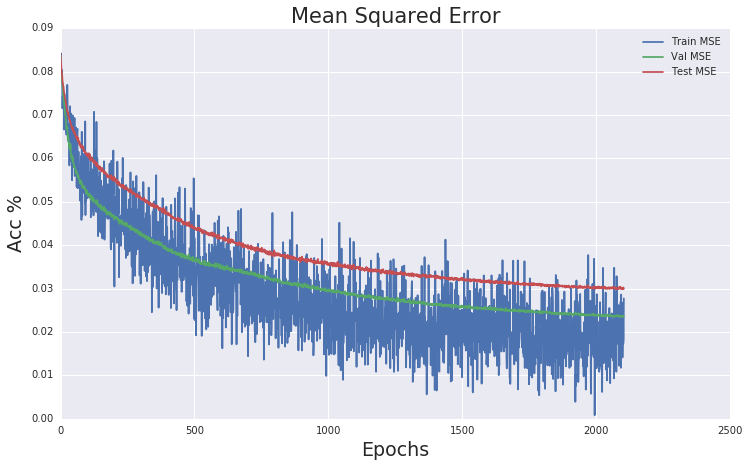

In [152]:
plt.figure(num=None, figsize=(12, 7), dpi=1000, facecolor='w', edgecolor='k')
plt.plot(net.mse_hist_train, label='Train MSE')
plt.plot(net.mse_hist_val, label='Val MSE')
plt.plot(net.mse_hist_test, label='Test MSE')
plt.legend()
plt.title('Mean Squared Error',fontsize=21)
plt.xlabel('Epochs',fontsize=19)
plt.ylabel('Acc %',fontsize=19)

## Problem 4

In [4]:
# Load data
data = DataManager('datasets/vowel.arff')
data.normalize()
x_train, x_test, y_train_num, y_test_num = data.test_train_split(.75)
y_train = one_hot(y_train_num, num_class=11)
y_test = one_hot(y_test_num, num_class=11)

In [162]:
results = []
for hd in [2**x for x in range(1,10)]:
    acc_list = []
    for i in range(5):
        net = NeuralNet(learning_rate=.01, hidden_dim=hd, epochs=2000)
        net.train(x_train, y_train_num, momentum=0, verbose=False)
        y_pred = net.predict(x_test)
        test_acc = np.mean(y_pred == y_test_num)
        acc_list.append(test_acc)
        
    avg = np.mean(acc_list)
    results.append(avg)

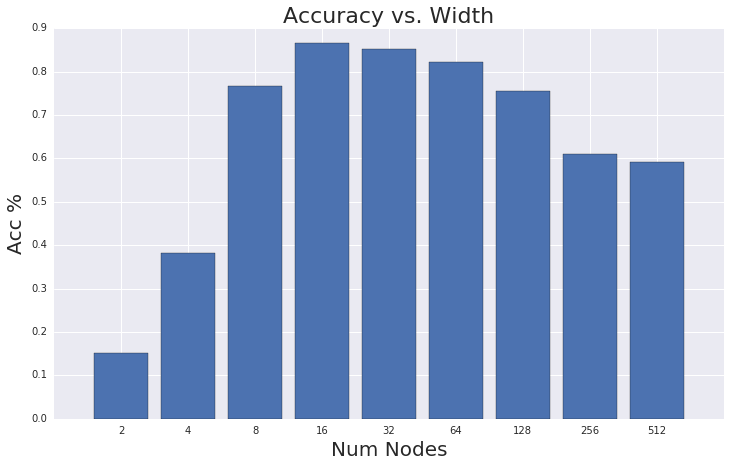

In [166]:
plt.figure(num=None, figsize=(12, 7), dpi=1000, facecolor='w', edgecolor='k')
plt.bar( range(9),results,tick_label=[2**x for x in range(1,10)], align='center')
plt.title('Accuracy vs. Width', fontsize=22)
plt.xlabel('Num Nodes', fontsize=20)
plt.ylabel('Acc %', fontsize=20)
plt.savefig('nodes-vs-acc.png')

In [60]:
net = NeuralNet(learning_rate=.01, hidden_dim=16, epochs=2000, early_stop=50)
net.train(x_train, y_train_num, x_test, y_test_num, momentum=.4, verbose=False)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:134: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


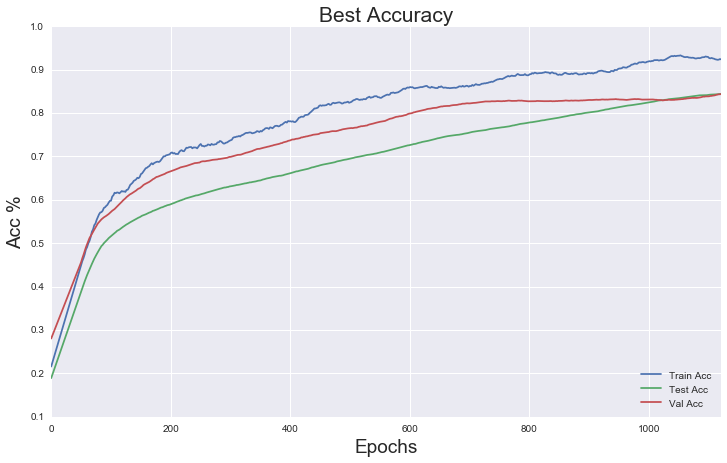

In [62]:
plt.figure(num=None, figsize=(12, 7), dpi=1000, facecolor='w', edgecolor='k')

x = range(len(net.acc_hist_train))
xx = np.linspace(0,len(net.acc_hist_train)-1, 1000)

itp1 = interp1d(x,net.acc_hist_train,kind='linear')
itp2 = interp1d(x,net.acc_hist_test,kind='linear')
itp3 = interp1d(x,net.acc_hist_val,kind='linear')

y1 = savgol_filter(itp1(xx), 51, 1)
y2 = savgol_filter(itp2(xx), 51, 1)
y3 = savgol_filter(itp3(xx), 51, 1)

plt.plot(xx, y1, label='Train Acc')
plt.plot(xx, y2, label='Test Acc')
plt.plot(xx, y3, label='Val Acc')


plt.legend(loc='lower right')
plt.title('Best Accuracy',fontsize=21)
plt.xlabel('Epochs',fontsize=19)
plt.ylabel('Acc %',fontsize=19)
plt.xlim(0,1120)
plt.savefig('prob-4.png')

## Problem 5

In [4]:
# Load data
data = DataManager('datasets/vowel.arff')
data.normalize()
x_train, x_test, y_train_num, y_test_num = data.test_train_split(.75)
y_train = one_hot(y_train_num, num_class=11)
y_test = one_hot(y_test_num, num_class=11)

In [5]:
results = []
for momentum in [.1*x for x in range(10)]:
    acc_list = []
    for i in range(5):
        net = NeuralNet(learning_rate=.01, hidden_dim=16, epochs=2000)
        net.train(x_train, y_train_num, momentum=momentum, verbose=False)
        y_pred = net.predict(x_test)
        test_acc = np.mean(y_pred == y_test_num)
        acc_list.append(test_acc)
        
    avg = np.mean(acc_list)
    results.append(avg)

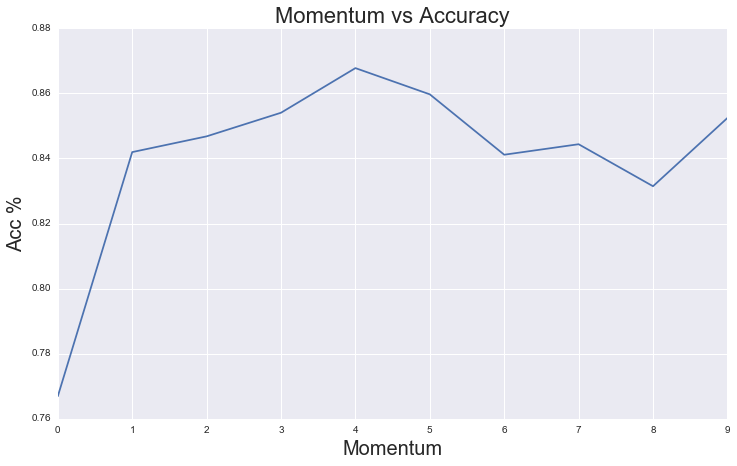

In [21]:
plt.figure(num=None, figsize=(12, 7), dpi=1000, facecolor='w', edgecolor='k')
#plt.bar(range(10), results,tick_label=[.1*x for x in range(10)], align='center')
plt.plot(results)
plt.title('Momentum vs Accuracy', fontsize=22)
plt.xlabel('Momentum',fontsize=20)
plt.ylabel('Acc %', fontsize=20)
plt.xlim(0,9)
plt.savefig('monetum.png')

## Problem 6

In [1]:
from __future__ import division, print_function, absolute_import

import numpy as np
import pickle
from mltools.nnet.layers import *
from mltools.nnet.load_data import load_data # uses Keras to load data
from mltools.nnet.optim import adam

# Hyperparameters
REG = 0
BATCH_SIZE = 28
WEIGHT_SCALE=.1
NUM_CLASSES = 10
PAD = 0
STRIDE = 1
EPOCHS = 10

# Load data
x_train, y_train, x_test, y_test, y_train_num, y_test_num = load_data('mnist')
x_train = np.swapaxes(x_train,1,3)
x_test = np.swapaxes(x_test,1,3)
print('\nLoaded Data:')
print('x_train: ', x_train.shape) # (60000, 28, 28, 1)
print('y_train: ', y_train.shape) # (10000, 28, 28, 1)
print('x_test: ', x_test.shape)# (60000, 10)
print('y_test: ', y_test.shape) # (10000, 10)

# Initialize weights to train
params = {}
params['W1'] = np.random.normal(scale=WEIGHT_SCALE, size=(32, 1, 3, 3))
params['W2'] = np.random.normal(scale=WEIGHT_SCALE, size=(32, 32, 3, 3))
params['W3'] = np.random.normal(scale=WEIGHT_SCALE, size=(24*24*32, NUM_CLASSES))
params['b1'] = np.zeros(32)
params['b2'] = np.zeros(32)
params['b3'] = np.zeros(NUM_CLASSES)

print('\nInitialized Paramaters:')
for name, tensor in params.iteritems():
    print('%s: ' % name, tensor.shape)

# For logging results
loss_hist = []
acc_hist = []
test_acc_hist = []

print('\nStarting Training:')
for epoch in range(EPOCHS):
    # Shuffle the data
    shuffle_idx = np.random.permutation(range(x_train.shape[0]))
    x_train = x_train[shuffle_idx]
    y_train = y_train[shuffle_idx]
    y_train_num = y_train_num[shuffle_idx]

    for i in range(int(x_train.shape[0] / BATCH_SIZE)):
        # Make minibatch
        batch_start = epoch*i
        batch_end = epoch*i + BATCH_SIZE
        x_batch = x_train[batch_start:batch_end]
        y_batch = y_train[batch_start:batch_end]
        y_batch_num = y_train_num[batch_start:batch_end]

        # Forward Pass
        # 1st Conv Layer
        h1, conv_cache_1 = conv_forward(x_batch, params['W1'], params['b1'], pad=PAD, stride=STRIDE)
        a1, relu_cache_1= relu_forward(h1)
        # 2nd Conv Layer
        h2, conv_cache_2 = conv_forward(a1, params['W2'], params['b2'], pad=PAD, stride=STRIDE)
        a2, relu_cache_2 = relu_forward(h2)
        # Fully Connected Layer
        h3, linear_cache_3 = linear_forward(a2, params['W3'], params['b3'])
        a3, relu_cache_3 = relu_forward(h3)

        # Loss
        probs, loss, dx = softmax_loss(a3, y_batch_num)
        # Plus regularization
        loss += .5 * REG * np.sum(params['W1']**2) + .5 * REG * np.sum(params['W2']**2) \
                + .5 * REG * np.sum(params['W3']**2)
        loss_hist.append(loss)

        # Backwards Pass
        grads = {}
        da_3 = relu_backward(dx, relu_cache_3)
        dx_2, grads['W3'], grads['b3'] = linear_backward(da_3, linear_cache_3)
        da_2 = relu_backward(dx_2, relu_cache_2)
        dx_3, grads['W2'], grads['b2'] = conv_backward(da_2, conv_cache_2)
        da_1 = relu_backward(dx_3, relu_cache_1)
        dx, grads['W1'], grads['b1'] = conv_backward(da_1, conv_cache_1)

        # Regularization (optional)
        grads['W3'] += REG * params['W3']
        grads['W2'] += REG * params['W2']
        grads['W1'] += REG * params['W1']

        # Parameter update
        for p, w in params.iteritems():
            dw = grads[p]
            next_w, next_config = sgd_momentum(w, dw,config={'momentum':.4,
                                                                      'learning_rate':.1})
            # Update weights
            params[p] = next_w
        
        # Calculate the accuracy
        if i % 1 == 0:
            probs = np.exp(a3 - np.max(a3, axis=1, keepdims=True))
            probs /= np.sum(probs, axis=1, keepdims=True)
            y_pred = np.argmax(probs, axis=1)
            train_acc = np.mean(y_pred == y_batch_num)
            acc_hist.append(train_acc)
            print("[{}] loss: {}, Acc: {}".format(i, loss, train_acc))

    # Calc Test Accuracy
    h1, conv_cache_1 = conv_forward(x_test, params['W1'], params['b1'], pad=PAD, stride=STRIDE)
    a1, relu_cache_1= relu_forward(h1)
    h2, conv_cache_2 = conv_forward(a1, params['W2'], params['b2'], pad=PAD, stride=STRIDE)
    a2, relu_cache_2 = relu_forward(h2)
    h3, linear_cache_3 = linear_forward(a2, params['W3'], params['b3'])
    a3, relu_cache_3 = relu_forward(h3)
    probs = np.exp(a3 - np.max(a3, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    y_pred = np.argmax(probs, axis=1)
    test_acc = np.mean(y_pred == y_test)
    test_acc_hist.append(test_acc)

    print("[{}] Epoch Complete: ".format(epoch))
    print("Test Acc: {}".format(test_acc))

print('\n---Completed Training---')


Loaded Data:
x_train:  (60000, 1, 28, 28)
y_train:  (60000, 10)
x_test:  (10000, 1, 28, 28)
y_test:  (10000, 10)

Initialized Paramaters:
W1:  (32, 1, 3, 3)
W3:  (18432, 10)
W2:  (32, 32, 3, 3)
b2:  (32,)
b3:  (10,)
b1:  (32,)

Starting Training:


Using TensorFlow backend.


NameError: name 'sgd_momentum' is not defined

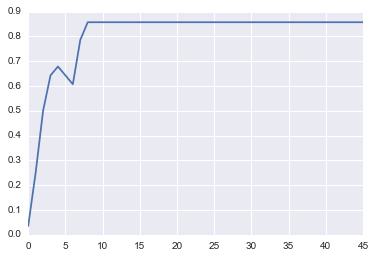

In [16]:
plt.plot(acc_hist[:])

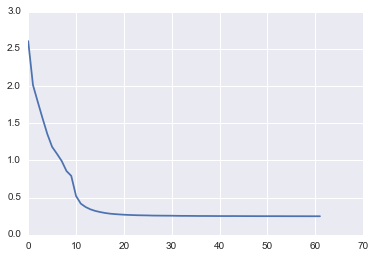

In [8]:
plt.plot(loss_hist)